In [1]:
import sys
print(sys.executable)

import torch
import math
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import time
from numpy import genfromtxt

from matplotlib import style
#style.use('seaborn-white')
#torch.cuda.empty_cache()

#gpytorch.settings.max_cg_iterations(2000)

%matplotlib inline
%load_ext autoreload
%autoreload 2

/work/flemingc/belal/anaconda3/envs/gpytorch/bin/python3


In [7]:
def cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt):
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [8]:
# Uncertainty Sources 
m1 = 1 
m2 = 0.1
length = 0.5
k_inertia = 1/3
mu_c = 0.0005
mu_p = 0.000002
gravity = 9.8 
dt = 0.01

# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []
theta_d_sim = [theta_d]
theta_sim = [theta]
x_dd_sim = []
x_d_sim = [x_d]
x_sim = [x]

noOfSteps = 12000
ts = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    force = 0.5*np.sin(6*ts[i]) #-0.2+
    #force = -1+np.sin(ts[i])+3*np.sin(2*ts[i])
    #force = -0.5+0.2*np.sin(ts[i])+0.3*np.sin(2*ts[i])
    theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)

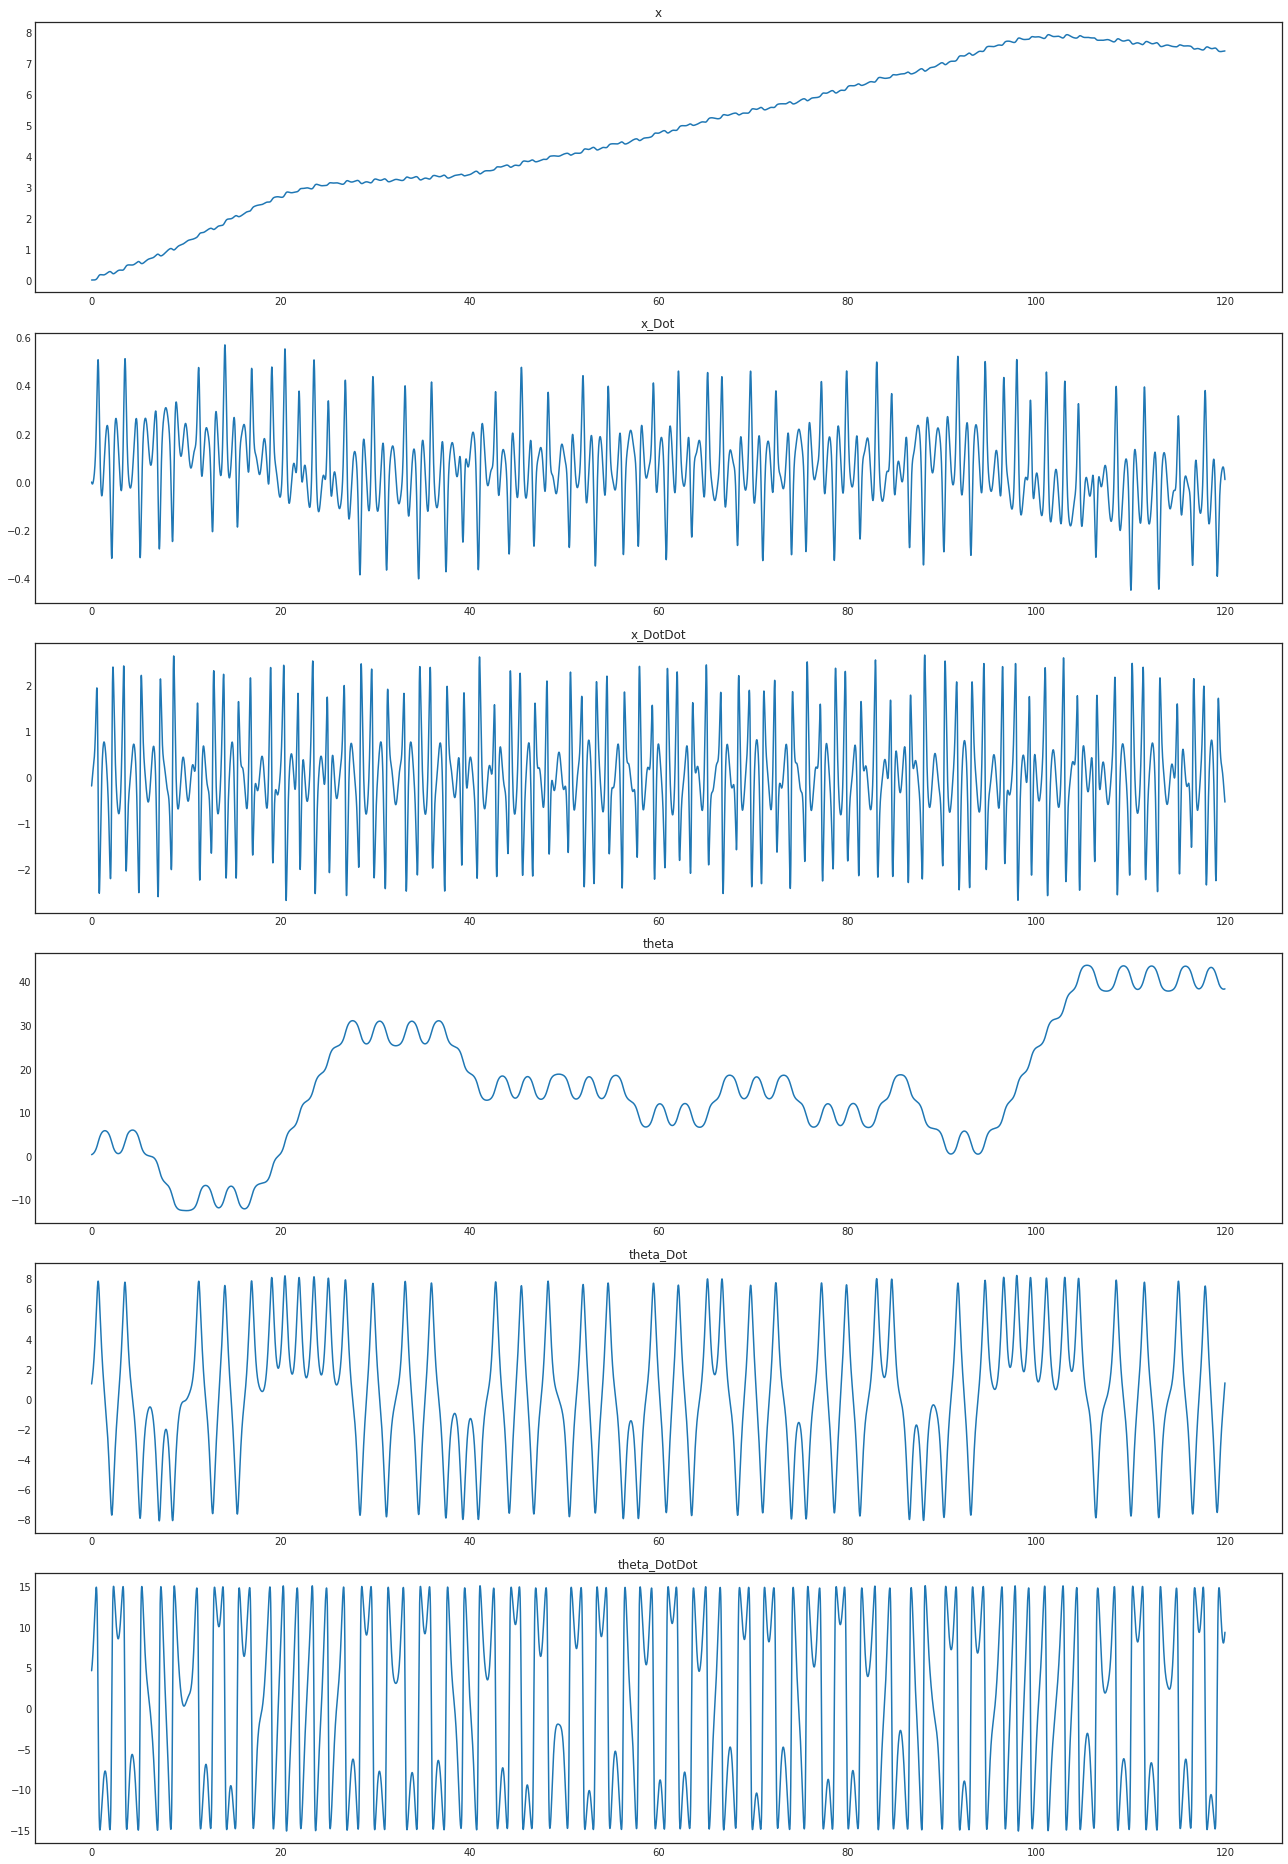

In [9]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

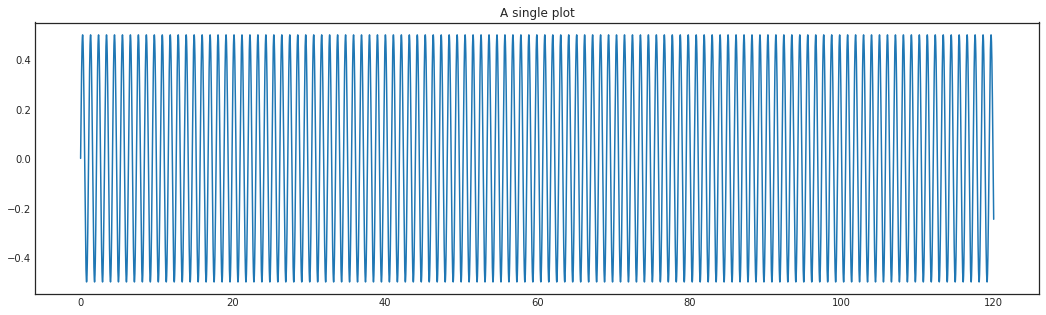

In [10]:
# Force Input Plot 
forceIn = 0.5*np.sin(6*timeSteps) #-0.2+
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax.set_title('A single plot')

In [11]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta_dd = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_train_x_dd = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)
Y_train_theta_d = ((theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev)  # RMSE(V)
Y_train_x_d = ((x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev)  # RMSE(V)

Y_train = np.stack((Y_train_theta_dd, Y_train_x_dd, Y_train_theta_d, Y_train_x_d), axis=1) # For MultiOutput GP

# Testing Output (Standardized)

Y_test_theta_dd = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x_dd = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)
Y_test_theta_d = ((theta_d_sim[en_Traj:]-theta_d_sim_mean)/theta_d_sim_stdev)  # RMSE(V)
Y_test_x_d = ((x_d_sim[en_Traj:]-x_d_sim_mean)/x_d_sim_stdev)  # RMSE(V)

X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [8]:
# Numpy to tensors 
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_prior = torch.from_numpy(X_prior).float()

# Putting tensors on GPU
X_train = X_train.cuda()
Y_train = Y_train.cuda()
X_prior = X_prior.cuda()

# MultiOutput GP

In [9]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=4
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=4), num_tasks=4, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=4, noise_prior=gpytorch.priors.SmoothedBoxPrior(0.15, 1.5, sigma=0.001))
#noise_prior=gpytorch.priors.SmoothedBoxPrior(0.15, 1.5, sigma=0.001))
#noise_constraint=gpytorch.constraints.GreaterThan(0.001)
model = MultitaskGPModel(X_train, Y_train, likelihood)

# putting on GPU
model = model.cuda()
likelihood = likelihood.cuda()

In [9]:
# Find optimal model hyperparameters
training_iter = 2000

model.train()
likelihood.train()

noiseTrain = np.zeros(training_iter)
lossTrain = np.zeros(training_iter)

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

start_time = time.time()

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train)
    loss.backward()
    if i%100 == 0:
        print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.likelihood.noise.item()
        ))
    noiseTrain[i] = model.likelihood.noise.item()
    lossTrain[i] = loss.item()
    optimizer.step()
    
print('Total time is %s:' %(time.time() - start_time))     

Iter 1/2000 - Loss: 1.235  noise: 0.693
Iter 101/2000 - Loss: 0.734  noise: 0.295
Iter 201/2000 - Loss: 0.278  noise: 0.103
Iter 301/2000 - Loss: 0.130  noise: 0.045
Iter 401/2000 - Loss: 0.066  noise: 0.025
Iter 501/2000 - Loss: 0.033  noise: 0.016
Iter 601/2000 - Loss: 0.014  noise: 0.011
Iter 701/2000 - Loss: 0.002  noise: 0.008
Iter 801/2000 - Loss: -0.006  noise: 0.007
Iter 901/2000 - Loss: -0.011  noise: 0.005
Iter 1001/2000 - Loss: -0.016  noise: 0.004
Iter 1101/2000 - Loss: -0.019  noise: 0.004
Iter 1201/2000 - Loss: -0.021  noise: 0.003
Iter 1301/2000 - Loss: -0.024  noise: 0.003
Iter 1401/2000 - Loss: -0.025  noise: 0.002
Iter 1501/2000 - Loss: -0.027  noise: 0.002
Iter 1601/2000 - Loss: -0.028  noise: 0.002
Iter 1701/2000 - Loss: -0.029  noise: 0.002
Iter 1801/2000 - Loss: -0.030  noise: 0.002
Iter 1901/2000 - Loss: -0.031  noise: 0.001
Total time is 17228.58316230774:


In [10]:
# save models 
#torch.save(model.state_dict(), '../../learnedModels/deterministicCase/GPwithGPyTorch/multi_RBF_gpytorch_Noise(0.002)Rank(1)Iter(2k)Train(8k)1')
#torch.save(model.state_dict(), '../../learnedModels/deterministicCase/GPwithGPyTorch/multi_RBF_gpytorch_Noise(0.001)Rank(1)Iter(2k)Train(8k)ForceIn')
#torch.save(model.state_dict(), '../../learnedModels/deterministicCase/GPwithGPyTorch/multi_RBF_gpytorch_Noise(Smooth)Rank(1)Iter(2k)Train(8k)ForceIn')


In [1]:
# Prediction one-by-one

#model.load_state_dict(torch.load('../../learnedModels/deterministicCase/GPwithGPyTorch/multi_RBF_gpytorch_Noise(Smooth)Rank(1)Iter(2k)Train(8k)ForceIn'))

#model.eval()
#likelihood.eval()

#sim_iter = 4500 

#mean = np.zeros((sim_iter,4))
#lower = np.zeros((sim_iter,4))
#upper = np.zeros((sim_iter,4))

#start_time = time.time()

# , gpytorch.settings.fast_pred_var()
#with torch.no_grad():
#    for i in range(sim_iter):
#        observed_pred = likelihood(model(X_prior[i+6500,:].reshape(1,-1)))
#        if i%200==0:
#            print(i)
#        interMean = observed_pred.mean
#        mean[i,:] = interMean.cpu().numpy()
#        interLow, interUp = observed_pred.confidence_region()
#        lower[i,:], upper[i,:] = interLow.cpu().numpy(), interUp.cpu().numpy()
#        torch.cuda.empty_cache()
        
#print('Total time is %s:' %(time.time() - start_time))          

In [10]:
# ALL Examples at once 

model.load_state_dict(torch.load('../../learnedModels/deterministicCase/GPwithGPyTorch/multi_RBF_gpytorch_Noise(Smooth)Rank(1)Iter(2k)Train(8k)ForceIn'))

model.eval()
likelihood.eval()

# , gpytorch.settings.fast_pred_var()
with torch.no_grad():
        observed_pred = likelihood(model(X_prior[:6000,:]))

In [11]:
torch.cuda.empty_cache()

In [12]:
# , gpytorch.settings.fast_pred_var()
with torch.no_grad():
        observed_pred1 = likelihood(model(X_prior[6000:,:]))

In [13]:
mean = observed_pred.mean.cpu().numpy()
lower, upper = observed_pred.confidence_region()
lower, upper = lower.cpu().detach().numpy(), upper.cpu().detach().numpy()

In [14]:
mean1 = observed_pred1.mean.cpu().numpy()
lower1, upper1 = observed_pred1.confidence_region()
lower1, upper1 = lower1.cpu().detach().numpy(), upper1.cpu().detach().numpy()

In [15]:
meanPred = np.vstack((mean, mean1))
lowerPred = np.vstack((lower, lower1))
upperPred = np.vstack((upper, upper1))
Y_theta_dd = np.concatenate((Y_train_theta_dd, Y_test_theta_dd), axis=0)
Y_x_dd = np.concatenate((Y_train_x_dd, Y_test_x_dd), axis=0)
Y_theta_d = np.concatenate((Y_train_theta_d, Y_test_theta_d[:-1]), axis=0)
Y_x_d = np.concatenate((Y_train_x_d, Y_test_x_d[:-1]), axis=0)

In [16]:
allData = np.stack((meanPred[:,0], lowerPred[:,0], upperPred[:,0], meanPred[:,1], lowerPred[:,1], upperPred[:,1], meanPred[:,2], lowerPred[:,2], upperPred[:,2],
                    meanPred[:,3], lowerPred[:,3], upperPred[:,3], Y_theta_dd, Y_x_dd, Y_theta_d, Y_x_d), axis=1)
#np.savetxt('MultiOutGPwithPytorchForceIn(Smooth).csv', allData, delimiter=',')

In [17]:
# Putting back on CPU
X_train = X_train.cpu()
Y_train = Y_train.cpu()
X_prior = X_prior.cpu()

Text(0.5, 0, 'time $(s)$')

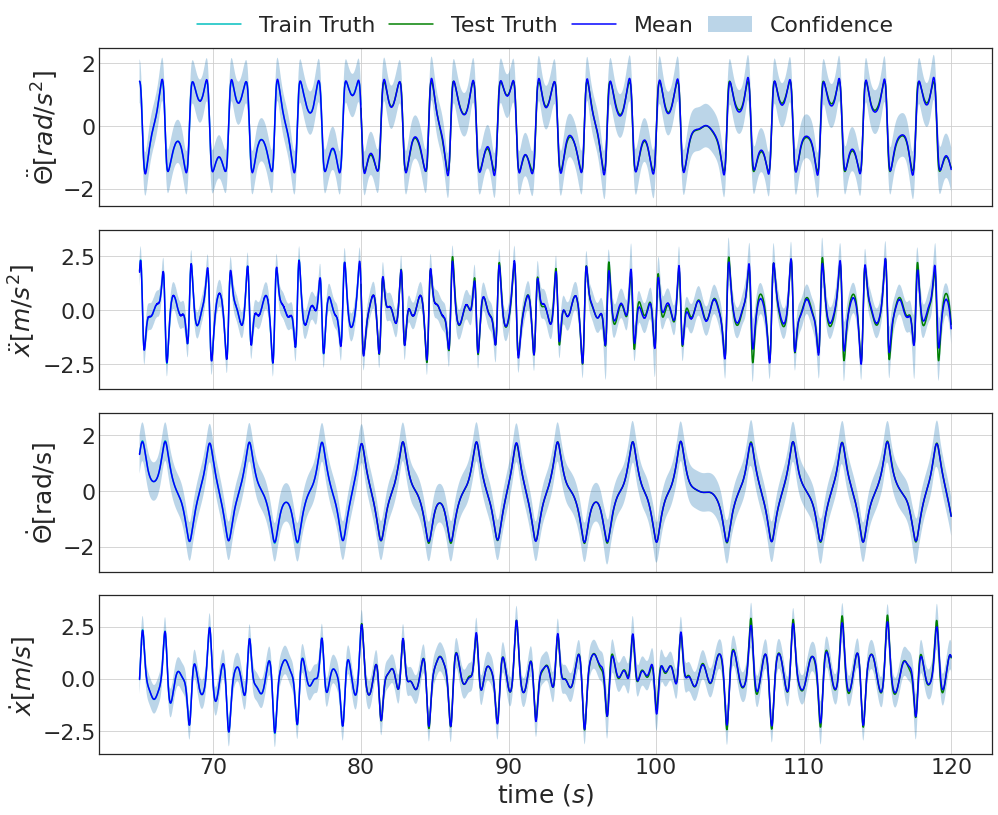

In [14]:
star_Traj = 6500
mids_Traj = 8000
ends_Traj = 12000

# Redefine dt, noOfSteps, timeSteps
# To generate plot without running too many cells 
dt = 0.01
noOfSteps = 12000
timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

# Reading form saved csv file 
meanPred = np.zeros((noOfSteps,4)) 
lowerPred = np.zeros((noOfSteps,4))
upperPred = np.zeros((noOfSteps,4))

Y_theta_dd = np.zeros((noOfSteps,4)) 
Y_x_dd = np.zeros((noOfSteps,4))
Y_theta_d = np.zeros((noOfSteps,4)) 
Y_x_d = np.zeros((noOfSteps,4))

my_data = genfromtxt('MultiOutGPwithPytorchForceIn(Smooth).csv', delimiter=',')
meanPred[:,0] = my_data[:,0]
lowerPred[:,0] = my_data[:,1]
upperPred[:,0] = my_data[:,2]

meanPred[:,1] = my_data[:,3]
lowerPred[:,1] = my_data[:,4]
upperPred[:,1] = my_data[:,5]

meanPred[:,2] = my_data[:,6]
lowerPred[:,2] = my_data[:,7]
upperPred[:,2] = my_data[:,8]

meanPred[:,3] = my_data[:,9]
lowerPred[:,3] = my_data[:,10]
upperPred[:,3] = my_data[:,11]

Y_theta_dd = my_data[:,12]
Y_x_dd = my_data[:,13]
Y_theta_d = my_data[:,14]
Y_x_d = my_data[:,15]


fig = plt.figure() 

gs = fig.add_gridspec(4, hspace=0.15)
ax = gs.subplots(sharex=True)

fig.set_figheight(13)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

# Get upper and lower confidence bounds
ax[0].plot(timeSteps[star_Traj:mids_Traj], Y_theta_dd[star_Traj:mids_Traj], 'c')
ax[0].plot(timeSteps[mids_Traj:ends_Traj], Y_theta_dd[mids_Traj:ends_Traj], 'g')
ax[0].plot(timeSteps[star_Traj:ends_Traj], meanPred[star_Traj:ends_Traj,0], 'b')
ax[0].fill_between(timeSteps[star_Traj:ends_Traj], lowerPred[star_Traj:ends_Traj,0], upperPred[star_Traj:ends_Traj,0], alpha=0.3)
ax[0].set_ylabel(r"$\ddot{\Theta}[rad/s^2]$")
ax[0].grid(True)
#ax[0].xaxis.set_ticks(np.arange(min(timeSteps), max(timeSteps), 10)-1)
ax[0].legend(('Train Truth', 'Test Truth', 'Mean', 'Confidence'), bbox_to_anchor=(0.1,1.02,0.8,0.2), mode='expand', loc='lower left', ncol=4, borderaxespad=0, shadow=False)

ax[1].plot(timeSteps[star_Traj:mids_Traj], Y_x_dd[star_Traj:mids_Traj], 'c')
ax[1].plot(timeSteps[mids_Traj:ends_Traj], Y_x_dd[mids_Traj:ends_Traj], 'g')
ax[1].plot(timeSteps[star_Traj:ends_Traj], meanPred[star_Traj:ends_Traj,1], 'b')
ax[1].fill_between(timeSteps[star_Traj:ends_Traj], lowerPred[star_Traj:ends_Traj,1], upperPred[star_Traj:ends_Traj,1], alpha=0.3)
ax[1].set_ylabel(r"$\ddot{x}[m/s^2]$")
ax[1].grid(True)

ax[2].plot(timeSteps[star_Traj:mids_Traj], Y_theta_d[star_Traj:mids_Traj], 'c')
ax[2].plot(timeSteps[mids_Traj:ends_Traj], Y_theta_d[mids_Traj:ends_Traj], 'g')
ax[2].plot(timeSteps[star_Traj:ends_Traj], meanPred[star_Traj:ends_Traj,2], 'b')
ax[2].fill_between(timeSteps[star_Traj:ends_Traj], lowerPred[star_Traj:ends_Traj,2], upperPred[star_Traj:ends_Traj,2], alpha=0.3)
ax[2].set_ylabel(r"$\dot{\Theta}$[rad/s]")
ax[2].grid(True)

ax[3].plot(timeSteps[star_Traj:mids_Traj], Y_x_d[star_Traj:mids_Traj], 'c')
ax[3].plot(timeSteps[mids_Traj:ends_Traj], Y_x_d[mids_Traj:ends_Traj], 'g')
ax[3].plot(timeSteps[star_Traj:ends_Traj], meanPred[star_Traj:ends_Traj,3], 'b')
ax[3].fill_between(timeSteps[star_Traj:ends_Traj], lowerPred[star_Traj:ends_Traj,3], upperPred[star_Traj:ends_Traj,3], alpha=0.3)
ax[3].set_ylabel(r"$\dot{x}[m/s]$")
ax[3].grid(True)
ax[3].set_xlabel('time $(s)$')

#plt.savefig('multi_RBF_gpytorch_Noise(Smooth)Rank(1)Iter(2k)Train(8k).png')

# Loss Plot

In [3]:
style.use('seaborn-white')
training_iter = 2000

star_Traj = 0
mids_Traj = 4000
ends_Traj = 4300

# Initialize plot
#fig, ax = plt.subplots(2)

#fig.set_figheight(12)
#fig.set_figwidth(16)

#ax[0].plot(timeSteps[:training_iter], lossTrain, 'k*')
#ax[1].plot(timeSteps[:training_iter], noiseTrain, 'k*')
#plt.savefig('multi_RBF_gpytorch_Noise(0.002)Rank(1)Iter(2k)Train(8k)1.png')

/tmp/ipykernel_3782048/2845719806.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


In [24]:
def plotTrainTestPerf(noOfPlots,sharedXAxisTitle:str, yAxisTitles:list, star_Traj:int, 
                      mids_Traj:int, ends_Traj:int, meanPred:np.ndarray, lowerPred:np.ndarray, 
                      upperPred:np.ndarray, sharedXAxis:np.array, origData:list, saveDir:str=None,
                      figHeight=13, figWidth=16):
    """
    sharedXAxis: np.array containing points for shared x-axis
    listOfYAxis: list of np.array containing points for each y-axis
    """    
    fig = plt.figure() 

    gs = fig.add_gridspec(noOfPlots, hspace=0.15)
    ax = gs.subplots(sharex=True)

    fig.set_figheight(figHeight)
    fig.set_figwidth(figWidth)

    plt.rc('font', size=22)          # controls default text sizes
    plt.rc('axes', titlesize=22)     # fontsize of the axes title
    plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
    plt.rc('legend', fontsize=22)    # legend fontsize
    plt.rc('figure', titlesize=12)  # fontsize of the figure title

    for i in range(noOfPlots):
        ax[i].plot(timeSteps[star_Traj:mids_Traj], origData[star_Traj:mids_Traj,i], 'c')
        ax[i].plot(timeSteps[mids_Traj:ends_Traj], origData[mids_Traj:ends_Traj,i], 'g')
        ax[i].plot(timeSteps[star_Traj:ends_Traj], meanPred[star_Traj:ends_Traj,i], 'b')
        ax[i].fill_between(timeSteps[star_Traj:ends_Traj], lowerPred[star_Traj:ends_Traj,i], 
                           upperPred[star_Traj:ends_Traj,i], alpha=0.3)
        ax[i].set_ylabel(yAxisTitles[i])
        ax[i].grid(True)
        ax[0].legend(('Train Truth', 'Test Truth', 'Mean', 'Confidence'), bbox_to_anchor=(0.1,1.02,0.8,0.2), 
                     mode='expand', loc='lower left', ncol=4, borderaxespad=0, shadow=False)
        ax[3].set_xlabel(sharedXAxisTitle)
    
    plt.show()
    if saveDir is not None:
      plt.savefig(saveDir)

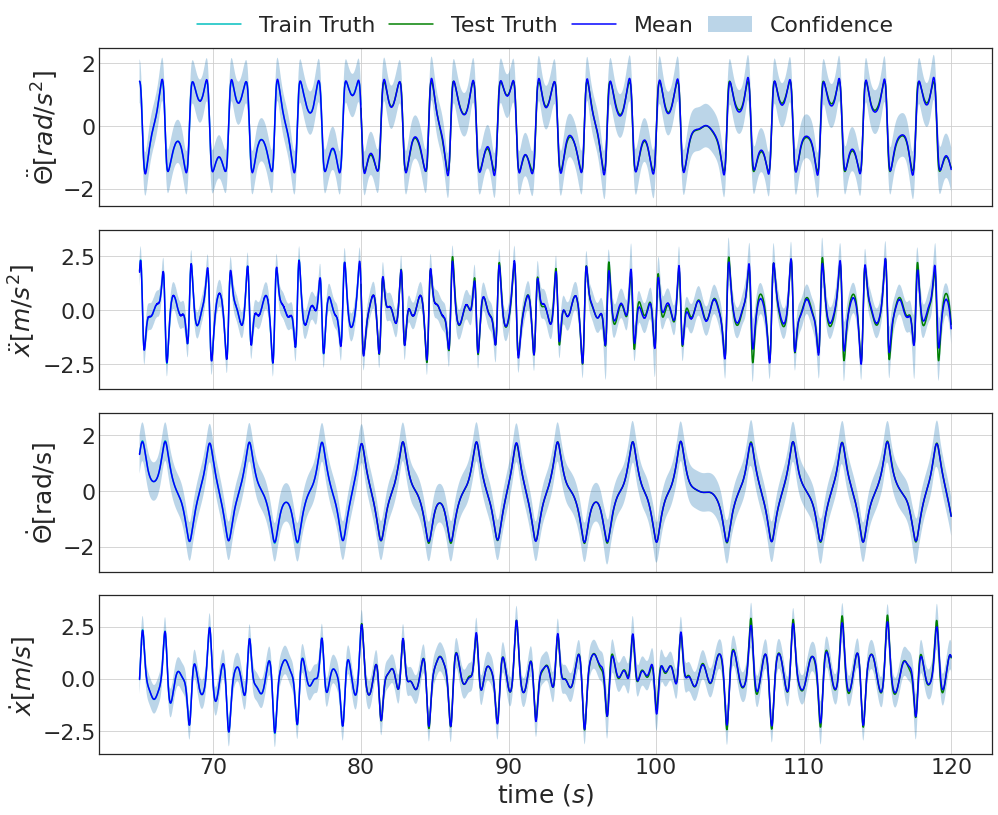

In [25]:
dt = 0.01
noOfSteps = 12000
timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)
origData = np.stack((Y_theta_dd,Y_x_dd,Y_theta_d,Y_x_d), axis=1)

plotTrainTestPerf(4, 'time $(s)$', [r"$\ddot{\Theta}[rad/s^2]$", r"$\ddot{x}[m/s^2]$",
                                     r"$\dot{\Theta}$[rad/s]", r"$\dot{x}[m/s]$"], 6500, 8000, 
                                     12000, meanPred, lowerPred, upperPred, timeSteps, origData)

(12000, 4)

In [20]:
Y_theta_d.shape

(12000,)